# Smoothing with Wave Transform Preprocessing

In [1]:
%load_ext autoreload
%autoreload 2
p = print

from os.path import join
import gc
import pickle

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from scipy.fftpack import fft, fftfreq, fftshift
from scipy import signal
import pywt

from crypr.util import get_project_path
from crypr.build import make_features, data_to_supervised, dwt_smoother

In [2]:
SYM = 'BTC'
TARGET = 'close'
Tx = 72
Ty = 1
TEST_SIZE = 0.05
data_path = join(get_project_path(), 'data', 'raw', SYM + '.csv')

In [3]:
data = pd.read_csv(data_path, index_col=0)
data.head()

,volumeto,volumefrom,open,high,close,low,time,timestamp
0,11679250.09,1420.13,8228.41,8231.84,8196.22,8188.29,1532836800,2018-07-29 06:00:00
1,8812752.64,1072.57,8196.44,8226.30,8211.36,8190.38,1532840400,2018-07-29 07:00:00
2,7966303.56,969.86,8211.37,8214.82,8200.12,8199.24,1532844000,2018-07-29 08:00:00
3,10236329.48,1246.57,8200.12,8216.15,8178.36,8175.14,1532847600,2018-07-29 09:00:00
4,13369556.62,1637.23,8178.36,8179.49,8153.85,8134.48,1532851200,2018-07-29 10:00:00


In [5]:
"""
Get percent change feature and target data.
"""
df = make_features(input_df=data, target_col='close')
X, y = data_to_supervised(input_df=df[['target__close']], target_ix=-1, Tx=Tx, Ty=Ty)
p(X.shape, y.shape)
X.head()

(5926, 72) (5926, 1)


,var1(t-72),var1(t-71),var1(t-70),var1(t-69),var1(t-68),var1(t-67),var1(t-66),var1(t-65),var1(t-64),var1(t-63),...,var1(t-10),var1(t-9),var1(t-8),var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1)
72,0.184719,-0.136884,-0.265362,-0.299693,0.130491,-0.175761,0.167850,0.563094,-0.177836,0.233308,...,0.089263,-0.749809,0.205035,-0.126087,0.364724,-0.757954,-1.407772,-0.132389,-0.112852,-0.102119
73,-0.136884,-0.265362,-0.299693,0.130491,-0.175761,0.167850,0.563094,-0.177836,0.233308,0.183582,...,-0.749809,0.205035,-0.126087,0.364724,-0.757954,-1.407772,-0.132389,-0.112852,-0.102119,-0.072524
74,-0.265362,-0.299693,0.130491,-0.175761,0.167850,0.563094,-0.177836,0.233308,0.183582,-0.589959,...,0.205035,-0.126087,0.364724,-0.757954,-1.407772,-0.132389,-0.112852,-0.102119,-0.072524,0.541471
75,-0.299693,0.130491,-0.175761,0.167850,0.563094,-0.177836,0.233308,0.183582,-0.589959,0.112213,...,-0.126087,0.364724,-0.757954,-1.407772,-0.132389,-0.112852,-0.102119,-0.072524,0.541471,-0.174064
76,0.130491,-0.175761,0.167850,0.563094,-0.177836,0.233308,0.183582,-0.589959,0.112213,0.244688,...,0.364724,-0.757954,-1.407772,-0.132389,-0.112852,-0.102119,-0.072524,0.541471,-0.174064,0.958425


In [6]:
"""
Confirm data reshape and target/feature creation was done correctly.
"""
y_values_except_last = np.squeeze(y.iloc[:-1].values)
t_minus_1_x_values_except_first = X.iloc[1:,-1].values

y_values_except_last.all() == t_minus_1_x_values_except_first.all()

True

In [7]:
"""
For comparing different transformations
"""
sample_ix = 1000
sample = X.iloc[sample_ix].values

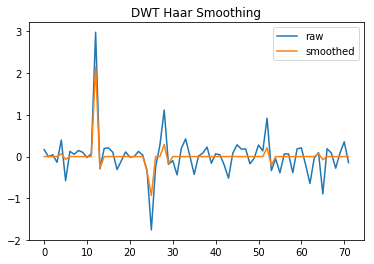

In [8]:
"""
DWT Haar Transform
"""
smoothed_sample = dwt_smoother(sample, 'haar', smooth_factor=.4)
plt.plot(sample, label='raw')
plt.plot(smoothed_sample, label='smoothed')
plt.title('DWT Haar Smoothing')
plt.legend()
plt.show()

In [9]:
"""
Apply the wavelet transformation smoothing to the feature data.
"""
wt_type = 'haar'
smoothing = .4
X_smooth = np.apply_along_axis(func1d=lambda x: dwt_smoother(x, wt_type, smooth_factor=smoothing), 
                               axis=-1, arr=X)

assert X_smooth.shape == X.shape

In [10]:
"""
Train Test Split.
"""
X_train, X_test, y_train, y_test = train_test_split(X_smooth, y, test_size=TEST_SIZE, shuffle=False)

In [11]:
# """
# Save data.
# """
# np.save(arr=X_train, file='../data/processed/X_train_{}_{}_smooth_{}'.format(SYM, wt_type, Tx))
# np.save(arr=X_test,  file='../data/processed/X_test_{}_{}_smooth_{}'.format(SYM, wt_type, Tx))
# np.save(arr=y_train, file='../data/processed/y_train_{}_{}_smooth_{}'.format(SYM, wt_type, Tx))
# np.save(arr=y_test,  file='../data/processed/y_test_{}_{}_smooth_{}'.format(SYM, wt_type, Tx))